In [5]:
import pandas as pd
from datetime import datetime
import sys
import os
import matplotlib.pyplot as plt
import json
import logging
from MSSQLDB_Datamanager import DataManager

## logger 設定
now = datetime.now()
log_filename = 'DBA_finproject_{}.log'.format(now.strftime('%Y-%m-%d'))
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s:%(levelname)s:%(message)s')
log_dir = '.\\var\\log'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
file_handler = logging.FileHandler('./var/log/' + log_filename)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

## config 讀取
cfg_path = r".\config.json"
with open(cfg_path, 'r', encoding='utf-8-sig') as f:
    cfg = json.load(f)
# databse connection information
db_cfg = cfg['db_connect']
db_cfg['creator'] = __import__(db_cfg['creator'])

In [6]:
## 資料區間設定
time_start = '2022-12-01'
time_end = '2023-03-31'
## query 資料
DM = DataManager(logger, db_cfg ,time_start, time_end)
# 撈所有表
# Behavior,MemberData,OrderData,OrderSlave,SalePageData,SegmentData = DM.read_ALL_data_from_db()
# 只撈其中一張
OrderData = DM.read_data_from_db(TableName= 'OrderData')

{message : return db query result}


In [13]:
OrderData = OrderData[(OrderData.StatusDef == 'Finish')|(OrderData.StatusDef == 'Return')]
OrderData.OrderDateTime = pd.to_datetime(OrderData.OrderDateTime,format='mixed')

In [4]:
M = OrderData.groupby("ShopMemberId")['TotalSalesAmount'].sum().reset_index()
M

,ShopMemberId,TotalSalesAmount
0,++1hXRq40ReP6O2WnFXBJOiuaJa8SMo2qkjDOFCkixY=,5620.0
1,++8jzBTrbtUA3nAmp9t4UOQFzUianOzm3BSPbu8u7Zo=,3870.0
2,++92QwZM9ZqJIPWq6vWH5Yn+R6Dc2TfiaqmWrbGe2Vg=,2760.0
3,++Jy+oNjw1RUQqmuA8uKlPrJckt8tzR0MiVhRnNrYzM=,7040.0
4,++QM3y2GEpSjTDUJQkgSPzua5h6EfqU6+8CbROFJ8E8=,6300.0
...,...,...
72825,zzAcABx340UTSgz17wYFRhLNSs741UL1JGPG45vmBvQ=,1894.0
72826,zzc8aYIwoIdrgsPDLZEEuv6me8dm17WUN5M45yqkQHo=,5838.0
72827,zzgc1OUPe+WRmcA0+BaIbrraZKfXaFGmMhAg4pYhygU=,5710.0
72828,zzkFT8mGysjhZhBUpDyNeypJ0s8a4ZRJLw4uFD1NUis=,2340.0


In [5]:
F = OrderData.groupby("ShopMemberId")['TradesGroupCode'].count().reset_index()
F

,ShopMemberId,TradesGroupCode
0,++1hXRq40ReP6O2WnFXBJOiuaJa8SMo2qkjDOFCkixY=,1
1,++8jzBTrbtUA3nAmp9t4UOQFzUianOzm3BSPbu8u7Zo=,2
2,++92QwZM9ZqJIPWq6vWH5Yn+R6Dc2TfiaqmWrbGe2Vg=,1
3,++Jy+oNjw1RUQqmuA8uKlPrJckt8tzR0MiVhRnNrYzM=,1
4,++QM3y2GEpSjTDUJQkgSPzua5h6EfqU6+8CbROFJ8E8=,2
...,...,...
72825,zzAcABx340UTSgz17wYFRhLNSs741UL1JGPG45vmBvQ=,1
72826,zzc8aYIwoIdrgsPDLZEEuv6me8dm17WUN5M45yqkQHo=,2
72827,zzgc1OUPe+WRmcA0+BaIbrraZKfXaFGmMhAg4pYhygU=,1
72828,zzkFT8mGysjhZhBUpDyNeypJ0s8a4ZRJLw4uFD1NUis=,1


In [6]:
maximum = max(OrderData.OrderDateTime)
maximum = maximum + pd.DateOffset(days = 1)
OrderData['day_diff'] = maximum - OrderData['OrderDateTime']
R = OrderData.groupby('ShopMemberId')['day_diff'].min().reset_index()

,ShopMemberId,day_diff
0,++1hXRq40ReP6O2WnFXBJOiuaJa8SMo2qkjDOFCkixY=,73 days 02:09:29.390000
1,++8jzBTrbtUA3nAmp9t4UOQFzUianOzm3BSPbu8u7Zo=,23 days 02:06:33.390000
2,++92QwZM9ZqJIPWq6vWH5Yn+R6Dc2TfiaqmWrbGe2Vg=,97 days 07:30:26.390000
3,++Jy+oNjw1RUQqmuA8uKlPrJckt8tzR0MiVhRnNrYzM=,32 days 06:34:51.390000
4,++QM3y2GEpSjTDUJQkgSPzua5h6EfqU6+8CbROFJ8E8=,68 days 09:28:53.390000
...,...,...
72825,zzAcABx340UTSgz17wYFRhLNSs741UL1JGPG45vmBvQ=,24 days 04:14:34.740000
72826,zzc8aYIwoIdrgsPDLZEEuv6me8dm17WUN5M45yqkQHo=,43 days 20:07:42.547000
72827,zzgc1OUPe+WRmcA0+BaIbrraZKfXaFGmMhAg4pYhygU=,34 days 05:13:09.390000
72828,zzkFT8mGysjhZhBUpDyNeypJ0s8a4ZRJLw4uFD1NUis=,110 days 08:10:24.390000


In [7]:
FM = M.merge(F, on = 'ShopMemberId', how = 'inner')
RFM = FM.merge(R, on = 'ShopMemberId')

In [ ]:
RFM.columns = ['ShopMemberId', 'Amount', 'Frequency', 'Recency']

In [26]:
A_list = RFM[(RFM.Frequency >= 2) & (RFM.Recency <= '90days')].ShopMemberId.tolist()
P_list = RFM[(RFM.Frequency >= 2) & (RFM.Recency > '90days')].ShopMemberId.tolist()
N_list = RFM[(RFM.Frequency == 1) & (RFM.Recency <= '90days')].ShopMemberId.tolist()

In [27]:
RFM['NAPL'] = None
RFM.NAPL = RFM.ShopMemberId.apply(lambda x: 'A' if x in A_list else 
                                  ('P' if x in P_list else 
                                   ('N' if x in N_list else 'L')))

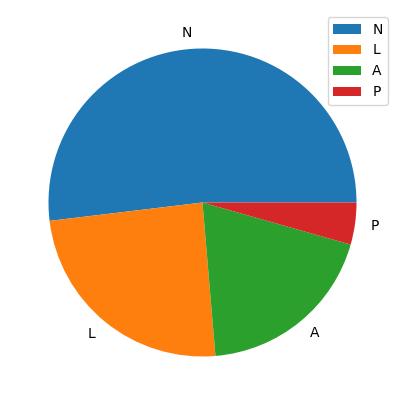

In [ ]:
plt.figure(figsize = (5,5))
plt.pie(RFM['NAPL'].value_counts(), labels =RFM['NAPL'].value_counts().reset_index().NAPL)
plt.legend(loc = 'upper right')
plt.show()